# Do it yourself

In the following notebook, you'll be exploring how you can load and visualise data using a set of simple Open Data Cube commands.

Before you get started, you should save this notebook to somewhere outside the `examples` folder, so that your work wont get overwritten when you next log in.

The work we'll be doing below is as follows:
1. Pick a study area anywhere in Australia
1. Explore available data products for your study area
1. Set up a datacube load command to load data for your study area
1. Plot data that has been loaded, exploring plotting of different timesteps
1. Export data to an image format to view on your local computer

Let's get started.

First, please use Google Maps to pick a study site in Australia and click on the map. You should be able to select the lat/lon coordiantes. Visit [maps.google.com](https://www.google.com/maps/@-28.6035447,135.9291226,4.93z) to select a site. The image below shows the coordinates that you can select at the bottom of the image.

![google maps coordinates](images/google_maps.jpg "Google Maps Coordinates")


*Note that there are three example study sites below that you can use if you like. Uncomment the one you'd like to look at. Once you've picked a site, you need to run or re-run each cell below to run the analysis on the new data.*

In [1]:
import datacube

dc = datacube.Datacube(app='do-it-yourself')
products = dc.list_products()
datacube.__version__

'1.6.2+357.gd6a6c091.dirty'

## Loading a cube of data

This next section does the load. First we set up a datacube object, `dc`, which has all the functions of the Open Data Cube library, and then we use the `dc.load()` function to load data. You can see the parameters that we've set below, but you can change them, for example, adding or removing measurements based on [product metadata](ODC_and_DEA_Metadata.ipynb).

In [2]:
%%time
import datacube

dc = datacube.Datacube(app='do-it-yourself')

# Somewhre in africa
coordinates = [-2.1483, 31.3258]

# For simplicity, store the centre X and Y coords
centre_x = coordinates[1]
centre_y = coordinates[0]

# And now make a bounding box with them
# Note that you can change the box_size to load more data. More data means longer load, though!
box_size = 0.1
bounding_box_x =  (centre_x - box_size, centre_x + box_size)
bounding_box_y =  (centre_y - box_size, centre_y + box_size)

# This command here does the loading of data
# Please be patient, it can take some time to load, depending on the size of your study area
# For the example study area, this took 30 seconds
datasets = dc.find_datasets(
    product='ls_usgs_wofs'
)

CPU times: user 20 ms, sys: 10 ms, total: 30 ms
Wall time: 50.8 ms


In [3]:
dataset = dc.load(
    product='ls_usgs_wofs',
    x=bounding_box_x,
    y=bounding_box_y,
    resolution=(30, 30),
    output_crs='EPSG:32736'
)

/usr/local/lib/python3.6/dist-packages/xarray/core/variable.py:134: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series(values.ravel())).reshape(values.shape)


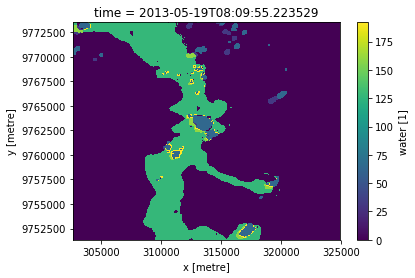

In [4]:
%matplotlib inline
dataset.water.isel(time=1).plot()


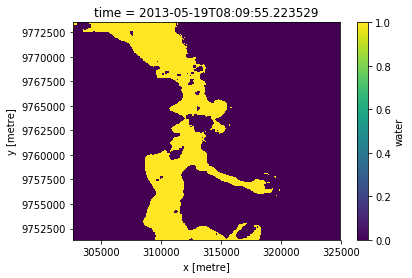

In [8]:
from datacube.storage import masking

wet = masking.make_mask(dataset.water.isel(time=1), wet=True)
wet.plot()

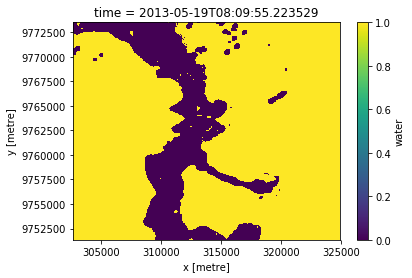

In [10]:
dry = masking.make_mask(dataset.water.isel(time=1), dry=True)
dry.plot()

## Plotting data

The next step uses Matplotlib to plot some data. We use a quick function to prepare the data, called `three_band_image`, which will prepare the measurements from the datacube we loaded into something Matplotlib expects. Later, we show another way to plot a simple single-band image.

You should experiment with plotting different timesteps or combinations of bands.

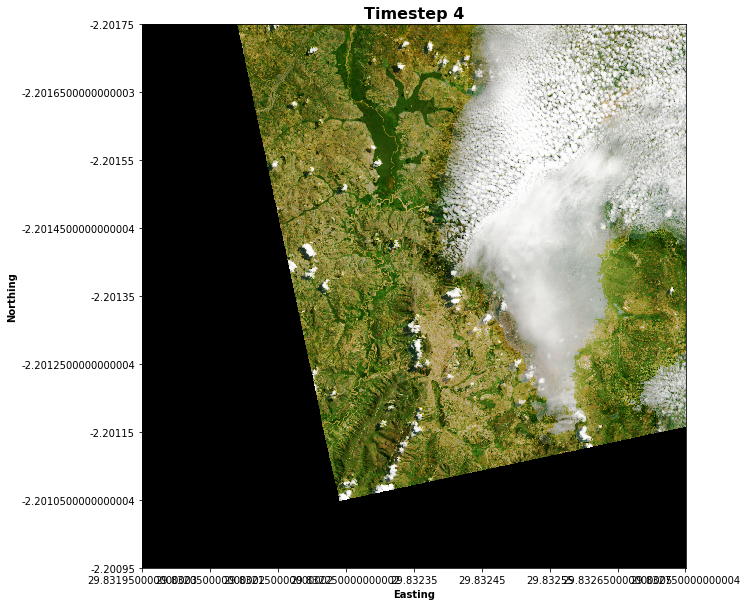

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# Note that this import should work if this notebook is either in examples or in the root folder.
try:
    from utils.utils import three_band_image
except ImportError:
    from examples.utils.utils import three_band_image


# Change these!
# You can change the time to anything from 0 to the number of timesteps - 1.
time = 4

# And bands can be any of the bands that we loaded above, so any of:
# 'nbar_red', 'nbar_green', 'nbar_blue', 'nbar_nir_1'
# You can experiment with plotting in false-colour, for example, try ['nbar_nir_1', 'nbar_green', 'nbar_blue']
bands = ['red', 'green', 'blue']
# bands = ['nbar_nir_1', 'nbar_green', 'nbar_blue']


# Prepare the image
img_toshow = three_band_image(
    data_cube,
    bands=bands,
    time=time
)

# And plot it
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_title("Timestep {}".format(time), fontweight='bold', fontsize=16)
ax.set_xticklabels(data_cube.longitude.values)
ax.set_yticklabels(data_cube.latitude.values)
ax.set_xlabel('Easting', fontweight='bold')
ax.set_ylabel('Northing', fontweight='bold')

plt.imshow(img_toshow)

##  Exporting data
The last task here is to export the data for your study site. You can change the name of the filename so that you know what the file is going to be called. After the file has been created, you can download it from the Jupyter directory it was exported into.

In [ ]:
from datacube import helpers

# You can change this, if you like.
filename = "example.tiff"

helpers.write_geotiff(dataset=data_cube.isel(time=0), filename=filename)

## Stretch goal: Calculate NDVI

If you've come this far and you'd like to do something a bit fancier, you can have a go at calculating the normalised difference vegetation index (NDVI) over your study site. There is a definition of what [NDVI is on Wikipedia](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index).

Basically, you need to use the following formula:

$$
\begin{aligned}
ndvi & = \frac{(nir - red)}{(nir + red)} \\
\end{aligned}
$$
    
Some hints:
 * You can access bands of an Xarray (the data format we're using) with their name, like this: `data_cube.bandname`
 * You can do simple math with bands by simply referring to them, like this: `data_cube.bandname_1 + data_cube.bandname_2`
 * The two band names you're after are `nbar_nir_1`, which is near infra-red, and `nbar_red`, which is red.


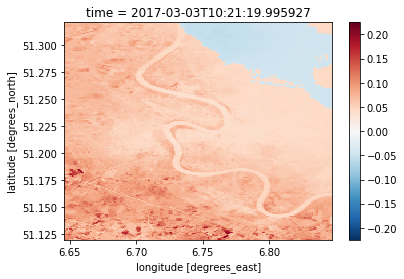

In [8]:
%matplotlib inline

# Calculate NDVI here
ndvi =  (data_cube.nir - data_cube.red) / (data_cube.nir + data_cube.red)

# This is the simple way to plot
# Note that high values are likely to be vegetation.
ndvi.isel(time=1).plot()